# Rreproduce Training.ipynb (tensorflow implimentation in )

In [2]:
import torch
import numpy as np

import sys
import itertools
import os

import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

import pandas as pd
sys.path.append('src')
from src.model import GMVAE

matplotlib.rcParams.update({'font.size': 24})

In [3]:
import importlib
import src.model
importlib.reload(src.model)
from src.model import GMVAE

In [61]:
def load(model, data):
    qy = model.encode_y(data)
    yp = np.argmax(qy, axis=1)
    z = model.encode_z(data)
    return qy, yp, z

def F2d_fixedrange(proj, n):
    # projection of PC1 and PC2
    pc1 = proj[:,0]
    pc2 = proj[:,1]
    if len(pc1) == len(pc2):
        length = len(pc1)
    else:
        print('length not equal')
        return 0
    
    pc1_min = pc1.min()
    pc1_max = pc1.max()
        
    
    pc2_min = pc2.min()
    pc2_max = pc2.max()

    dmin = min(pc1_max - pc1_min, pc2_max - pc2_min)
    dx = dmin / n

    x = np.arange(pc1_min, pc1_max, dx)
    y = np.arange(pc2_min, pc2_max, dx)
    
    density_matrix = np.zeros(shape = (len(y), len(x)))
    for i in range(length):
        index1 = int((pc1[i] - pc1_min) / dx)
        index2 = int((pc2[i] - pc2_min) / dx)
        if (index2 >= 0) and (index1 >= 0):
            try:
                density_matrix[index2, index1] += 1
            except:
                pass

    return density_matrix, pc1_min, pc1_max, pc2_min, pc2_max, dx

# f2d is the free energy landscape
def plot_F_fixedrange(proj, title, n1 = 25, n2 = 10):
    f2d, pc1_min, pc1_max, pc2_min, pc2_max, dx = F2d_fixedrange(proj, n1)

    x = np.arange(pc1_min, pc1_max, dx)
    y = np.arange(pc2_min, pc2_max, dx)
    X, Y = np.meshgrid(x, y)
    params={ 'font.size': 24}
    plt.rcParams.update(params)
    plt.figure(figsize=(10, 8))
    ax = plt.axes()
    ax.set_facecolor('Silver')
    plt.contourf(X, Y, f2d, levels = np.linspace(1, f2d.max() + 1, n2))


    plt.colorbar(label = 'density')
    #plt.contour(X, Y, f2d, levels = np.arange(1, f2d.max() + 1, number), colors = ('k'), linewidths = 1)

    plt.xlabel(r'$z_1$')
    plt.ylabel(r'$z_2$')
    plt.title(title, fontsize = 24)
    #plt.show()
    params={ 'font.size': 18}
    plt.rcParams.update(params)
    return 0

def plot_classes(data, y_pred, k=5): 
    matplotlib.rcParams.update({'font.size': 20})
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    sc = axes.scatter(data[:,0], data[:,1], c=y_pred, alpha=1, 
                    cmap=plt.cm.get_cmap('jet', k), s=1)
    cbar = fig.colorbar(sc, ax=axes)
    cbar.set_alpha(1)
    cbar.set_ticks(np.arange(0, 5, 1))
    cbar.set_label('Cluster index', labelpad=20)
    sc.set_alpha(1)
    sc.set_clim(-0.5, k - 0.5)
    cbar.draw_all()

    axes.set_xlabel(r'$z_1$')
    axes.set_ylabel(r'$z_2$')



In [5]:
readdir = '../data/'
modeldir = 'models/'

In [6]:
# Load data
data = torch.load(readdir + "d_matrix.pt")

#dataset = load_and_mix_data_nolabel(data=data, test_ratio=0.01)

In [23]:
# Hyperparameters
k, n_x, n_z, n_epochs = 5, 531, 2, 401
qy_dims = [32]
qz_dims = [16]
pz_dims = [16]
px_dims = [128]
r_nent = 0.3
batch_size = 5000
lr = 1e-4

model_path = modeldir + 'test/' 


In [7]:
lengths = [int(p * len(data)) for p in [0.95,0.05]]
tr,v = torch.utils.data.random_split(data,lengths)
train_sampler = torch.utils.data.SubsetRandomSampler(tr.indices)
val_sampler = torch.utils.data.SubsetRandomSampler(v.indices)

# set batch size and set up the data generators for train, val, test sets
trainloader = torch.utils.data.DataLoader(data,batch_size=batch_size,sampler=train_sampler)
valloader = torch.utils.data.DataLoader(data,batch_size=batch_size,sampler=val_sampler)

In [69]:
len(next(iter(valloader)))

2000

In [26]:
model0 = GMVAE(model_path, k=k, n_x=n_x, n_z=n_z, qy_dims = qy_dims,
              qz_dims = qz_dims, pz_dims = pz_dims, px_dims = px_dims,
              r_nent = r_nent,lr=lr)

In [28]:
model0.train_model(trainloader, valloader, 1501)

    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.47e+00, -2.49e+02,  1.47e+00, -2.48e+02,         0
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.48e+00, -3.11e+02,  1.48e+00, -3.12e+02,        50
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.46e+00, -4.19e+02,  1.46e+00, -4.21e+02,       100
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.20e+00, -4.73e+02,  1.19e+00, -4.80e+02,       150
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  4.41e-01, -5.58e+02,  4.34e-01, -5.64e+02,       200
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.39e-01, -5.91e+02,  1.37e-01, -5.77e+02,       250
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  5.66e-02, -5.90e+02,  5.58e-02, -5.99e+02,       300
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  2.60e-02, -6.42e+02,  2.56e-02, -6.43e+02,       350
    tr_ent,   tr_loss,   val_ent,  val_loss,     epoch
  1.34e-02, -6.45e+02,  1.33e-02, -6.47e+02,       400
    tr_ent

KeyboardInterrupt: 

In [30]:
qy0, yp0, z0 = load(model0, data)

/tmp/ipykernel_31131/2938653305.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('jet', k), s=1)
/tmp/ipykernel_31131/2938653305.py:80: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cbar.draw_all()


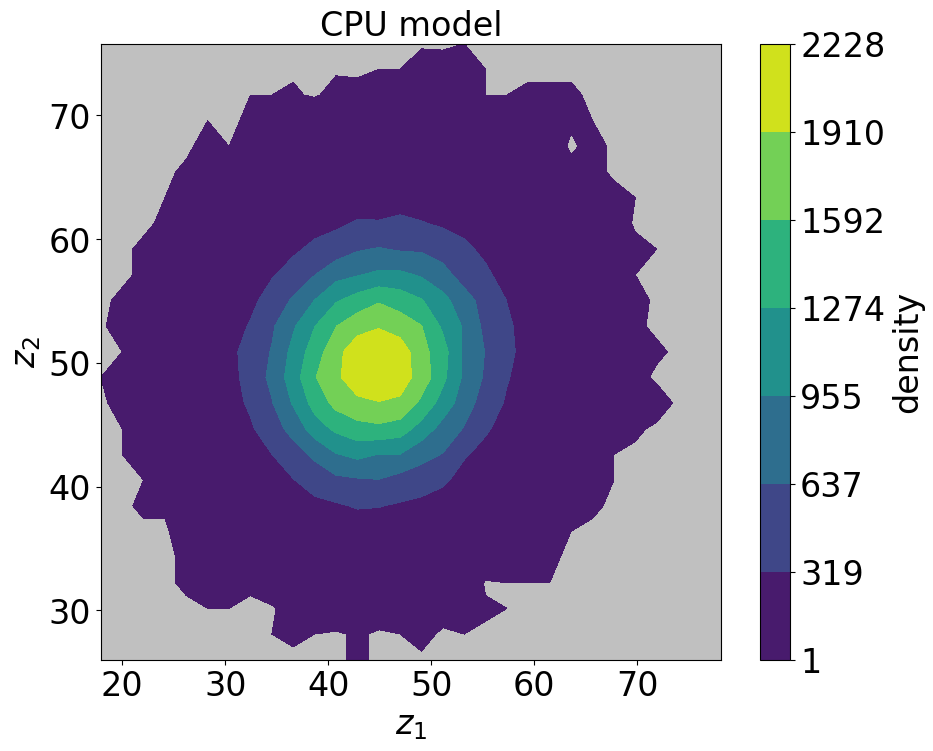

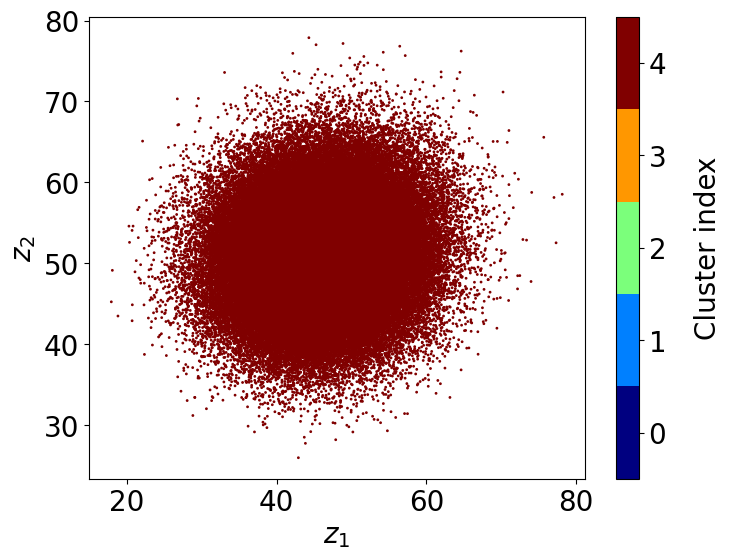

In [33]:
plot_F_fixedrange(z0.detach().numpy(), 'CPU model', n1 = 25, n2 = 8)
plot_classes(z0.detach().numpy(), yp0.detach().numpy())

In [9]:
# Hyperparameters
k, n_x, n_z, n_epochs = 5, 531, 2, 401
qy_dims = [16,16]
qz_dims = [16,16]
pz_dims = [16,16]
px_dims = [16,16]
r_nent = 0.3
batch_size = 2000
lr = 1e-5

model_path = modeldir + 'testrna/' 

if not os.path.exists(model_path):
    os.makedirs(model_path)

model1= GMVAE(model_path, k=k, n_x=n_x, n_z=n_z, qy_dims = qy_dims,
              qz_dims = qz_dims, pz_dims = pz_dims, px_dims = px_dims,
              r_nent = r_nent,lr=lr)

In [13]:
loss = torch.load("models/testrna/loss.pt")
model1.load_state_dict(torch.load("models/testrna/model.pt"))

<All keys matched successfully>

In [14]:
qy1, yp1, z1 = load(model1, data)

/tmp/ipykernel_265/2938653305.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('jet', k), s=1)
/tmp/ipykernel_265/2938653305.py:80: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cbar.draw_all()


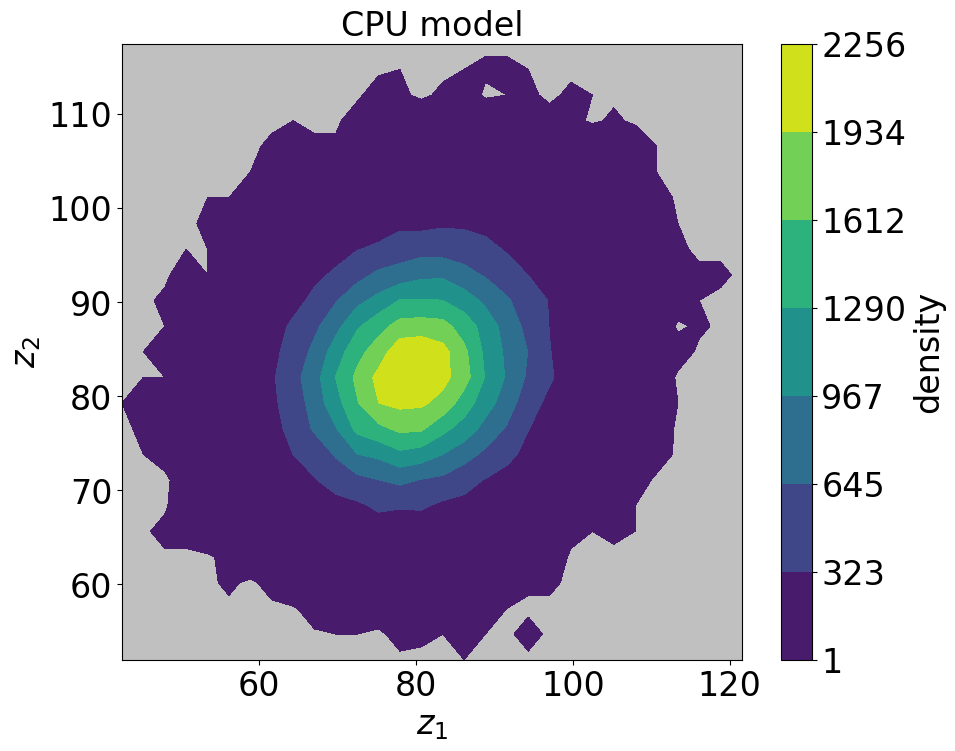

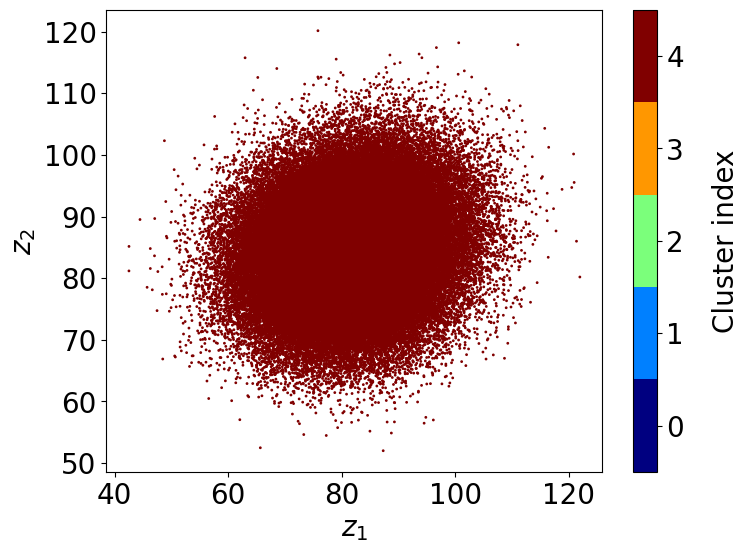

In [15]:
plot_F_fixedrange(z1, 'CPU model', n1 = 25, n2 = 8)
plot_classes(z1, yp1)